In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import time

In [3]:
import os
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers, losses
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, classification_report


In [4]:
train_images = []
train_labels = []
test_images = []
test_labels = []

In [5]:
for category in range(4):
    images = [img_to_array(load_img(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}/{file}', color_mode='grayscale', target_size=(90, 120))) for file in os.listdir(f'/content/drive/My Drive/Myocardial Infraction CNN/{category}')]

    labels = [category] * len(images)

    train_images_category, test_images_category, train_labels_category, test_labels_category = train_test_split(images, labels, test_size=0.2)

    train_images.extend(train_images_category)
    test_images.extend(test_images_category)
    train_labels.extend(train_labels_category)
    test_labels.extend(test_labels_category)

In [6]:
x_train = np.array(train_images)
x_test = np.array(test_images)
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

In [7]:
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.

In [8]:
start_time = time.time()


In [9]:
from tensorflow.keras.applications import VGG19


In [10]:
x_train = np.array([np.repeat(img, 3, axis=-1) for img in x_train])
x_test = np.array([np.repeat(img, 3, axis=-1) for img in x_test])

In [11]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]))


In [12]:
for layer in base_model.layers:
    layer.trainable = False

In [13]:
vgg_model = tf.keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(4, activation='softmax')
])

In [14]:
vgg_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
history3 = vgg_model.fit(x_train, train_labels, epochs=100, validation_data=(x_test, test_labels))


Epoch 1/100
24/24 [==============================] - 4s 53ms/step - loss: 1.3712 - accuracy: 0.3563 - val_loss: 1.2663 - val_accuracy: 0.4278
Epoch 2/100
24/24 [==============================] - 1s 26ms/step - loss: 1.2025 - accuracy: 0.4669 - val_loss: 1.1924 - val_accuracy: 0.4064
Epoch 3/100
24/24 [==============================] - 1s 23ms/step - loss: 1.1403 - accuracy: 0.4858 - val_loss: 1.1089 - val_accuracy: 0.4866
Epoch 4/100
24/24 [==============================] - 1s 27ms/step - loss: 1.0643 - accuracy: 0.5628 - val_loss: 1.0745 - val_accuracy: 0.5668
Epoch 5/100
24/24 [==============================] - 1s 26ms/step - loss: 1.0233 - accuracy: 0.5735 - val_loss: 1.1595 - val_accuracy: 0.4652
Epoch 6/100
24/24 [==============================] - 1s 23ms/step - loss: 0.9851 - accuracy: 0.5735 - val_loss: 1.0516 - val_accuracy: 0.5561
Epoch 7/100
24/24 [==============================] - 1s 24ms/step - loss: 0.9750 - accuracy: 0.6032 - val_loss: 1.0345 - val_accuracy: 0.5829
Epoch 

6/6 [==============================] - 0s 17ms/step - loss: 0.7405 - accuracy: 0.7701


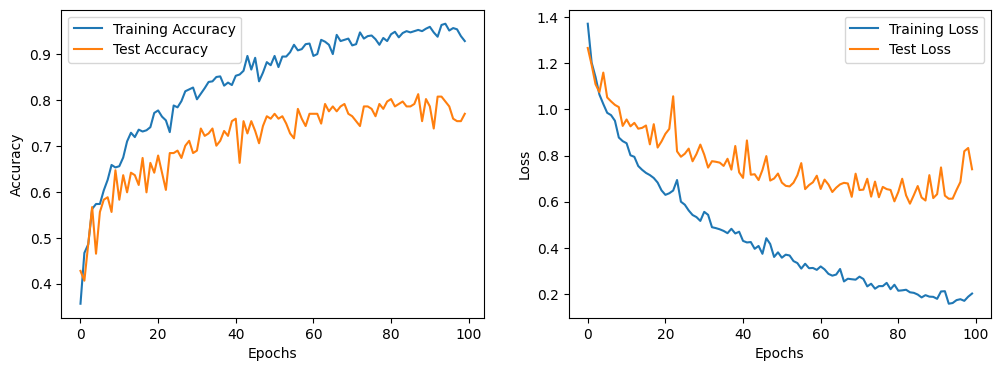

In [16]:
test_loss, test_acc = vgg_model.evaluate(x_test, test_labels)


plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Training Accuracy')
plt.plot(history3.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Training Loss')
plt.plot(history3.history['val_loss'], label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [17]:
predictions = vgg_model.predict(x_test)
binary_predictions = np.argmax(predictions, axis=1)
test_labels = test_labels.reshape(-1, 1)
conf_matrix = confusion_matrix(test_labels, binary_predictions)

6/6 [==============================] - 0s 13ms/step


In [18]:
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
precision = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=0)
recall = np.diagonal(conf_matrix) / np.sum(conf_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)


num_classes = len(conf_matrix)
specificity = []
for i in range(num_classes):
    true_negatives = np.sum(conf_matrix) - np.sum(conf_matrix[i, :]) - np.sum(conf_matrix[:, i]) + conf_matrix[i, i]
    false_positives = np.sum(conf_matrix[:, i]) - conf_matrix[i, i]
    specificity_class = true_negatives / (true_negatives + false_positives)
    specificity.append(specificity_class)

average_specificity = np.mean(specificity)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Specificity for each class: {specificity}")
print(f"Average Specificity: {average_specificity}")

Confusion Matrix:
[[48  0  0  0]
 [ 2 25 13  7]
 [ 2  1 30  2]
 [ 2  3 11 41]]
Accuracy: 0.7701
Precision: [0.88888889 0.86206897 0.55555556 0.82      ]
Recall: [1.         0.53191489 0.85714286 0.71929825]
F1 Score: [0.94117647 0.65789474 0.6741573  0.76635514]
Specificity for each class: [0.9568345323741008, 0.9714285714285714, 0.8421052631578947, 0.9307692307692308]
Average Specificity: 0.9252843994324493


In [19]:
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Training took {elapsed_time} seconds.")

Training took 65.22084665298462 seconds.
